___That's cool_. Computational sociolinguistic methods for investigating individual lexico-grammatical variation__

_

Hans-Jörg Schmid (1),   
Quirin Würschinger (1),   
Sebastian Fischer (2),  
Helmut Küchenhoff (2)

(1) Department of English and American Studies, LMU Munich, Germany  
(2) Department of Statistics, LMU Munich, Germany

Correspondence 

* regarding the paper: <hans-joerg.schmid@lmu.de>
* regarding this script: <q.wuerschinger@lmu.de>

### Functionality

* the script parses the XML version of BNC2014
* performs queries for the target pattern `that's ADJ`
* calculates total word counts in the corpus for individual speakers
* outputs hits to `csv` files
* joins metadata for hits from the metadata spreadsheets provided by BNC2014
* joins semantic category descriptions from the USAS tagset

# Load packages

Package requirements can be seen in `requirements.yml`.

In [1]:
import os
import random
from collections import defaultdict
from pprint import pprint

import numpy as np
import pandas as pd

from lxml import etree

import altair as alt
#alt.data_transformers.disable_max_rows()

# Variables

BNC2014 needs to be downloaded for this script to work. It can be obtained from the official [BNC website](http://corpora.lancs.ac.uk/bnc2014/). 

The following variables need to be updated to the corpus' local path. In the current setting it was installed in the project folder in the folder `data`.

In [3]:
dir_corpus = 'data/spoken/tagged/'
dir_meta = 'data/spoken/metadata/'

# Load and parse XML

In [4]:
f_names = os.listdir(dir_corpus)
f_paths = [f"{dir_corpus}{f_name}" for f_name in f_names]

In [5]:
def get_xml(f_path):
    with open(f_path, 'r') as f:
        f = f.read()
    xml = etree.fromstring(f)
    return xml

# Corpus size

## Texts

Calculate the total number of texts in the corpus.

In [7]:
%%time
texts = []
for f_path in f_paths:
    xml = get_xml(f_path)
    id = xml.get('id')
    texts.append(id)

CPU times: user 47 s, sys: 7.94 s, total: 54.9 s
Wall time: 1min 2s


In [9]:
len(texts)

1251

## Speakers

1. Store all speakers in the corpus.
2. Store the total number of words each speaker has contributed to the corpus.

In [10]:
%%time
speakers_words = defaultdict(int)
for f_path in f_paths:
    xml = get_xml(f_path)
    for u in xml.iter('u'):
        speaker = u.get('who')
        n_words = len([w for w in u.iter('w')])
        speakers_words[speaker] += n_words

CPU times: user 53 s, sys: 7.54 s, total: 1min
Wall time: 1min 6s


### Number of speakers

In [11]:
len(speakers_words)

671

### Words per speaker

In [15]:
df_speakers_words = pd.DataFrame(list(speakers_words.items()), columns=['speaker', 'n_words'])

In [16]:
df_speakers_words.sort_values('speaker', ascending=True, inplace=True)

In [17]:
df_speakers_words

speaker  n_words
468      S0001     3000
459      S0002     8535
440      S0003     1893
312      S0004     3634
143      S0005     1449
..         ...      ...
219      S0691     2135
214      S0692     1105
26   UNKFEMALE    28108
32     UNKMALE    30316
5     UNKMULTI     1375

[671 rows x 2 columns]

### Write out

In [18]:
with open('out/metadata/speakers_words.csv', 'w') as f_out:
    df_speakers_words.to_csv(f_out, index=False)

## Words

In [270]:
%%time
n_words = 0
for f_path in f_paths:
    xml = get_xml(f_path)
    for w in xml.iter('w'):
        n_words += 1

CPU times: user 1min 33s, sys: 3.04 s, total: 1min 36s
Wall time: 1min 43s


In [12]:
n_words

11422615

# Queries

## `the`

In [59]:
def get_the(u):
    query = "the"
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.get('lemma') == 'the':
            hit = {}
            hit['doc'] = xml.get('id')
            hit['utterance'] = u.get('n')
            hit['speaker'] = u.get('who')
            hit['query'] = query
            hit['result'] = w.text
            hits.append(hit)
    return hits    

## `I`

In [60]:
def get_i(u):
    query = "I"
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.text == 'I':
            hit = {}
            hit['doc'] = xml.get('id')
            hit['utterance'] = u.get('n')
            hit['speaker'] = u.get('who')
            hit['query'] = query
            hit['result'] = w.text
            hits.append(hit)
    return hits    

## `that's ADJ`

In [6]:
blacklist = [
    'to',
    'timing', 'news',  'bullshit', 'awesome', 'enough'
]

### plain

In [7]:
def get_thats_adj_plain(u):
    query = "that 's ADJ - plain"
    n_slots = 3
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.text.lower() == 'that':
            if words.index(w) + n_slots - 1 < len(words):
                w2 = words[words.index(w) + 1]
                w3 = words[words.index(w) + 2]
                if w2.text.lower() == "'s":
                    if w3.get('pos') == "JJ":
                        hit = {}
                        hit['doc'] = xml.get('id')
                        hit['utterance'] = u.get('n')
                        hit['speaker'] = u.get('who')
                        hit['query'] = query
                        hit['result'] = ' '.join(
                            [
                                w.text,
                                w2.text,
                                w3.text,
                            ]
                        )
                        hit['adj_text'] = w3.text
                        hit['adj_semtag'] = w3.get('usas')
                        # check following item
                        if words.index(w) + n_slots < len(words):
                            w4 = words[words.index(w) + n_slots]
                            if w4.text.lower() not in blacklist:
                                hits.append(hit)
                        else:
                            hits.append(hit)
    return hits    

### dd1

In [8]:
def get_thats_adj_dd1(u):
    query = "that 's ADJ - dd1"
    n_slots = 3
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.text.lower() == 'that' and w.get('pos') == 'DD1':
            if words.index(w) + n_slots - 1 < len(words):
                w2 = words[words.index(w) + 1]
                w3 = words[words.index(w) + 2]
                if w2.text.lower() == "'s":
                    if w3.get('pos') == "JJ":
                        hit = {}
                        hit['doc'] = xml.get('id')
                        hit['utterance'] = u.get('n')
                        hit['speaker'] = u.get('who')
                        hit['query'] = query
                        hit['result'] = ' '.join(
                            [
                                w.text,
                                w2.text,
                                w3.text,
                            ]
                        )
                        hit['adj_text'] = w3.text
                        hit['adj_semtag'] = w3.get('usas')
                        # check following item
                        if words.index(w) + n_slots < len(words):
                            w4 = words[words.index(w) + n_slots]
                            if w4.text.lower() not in blacklist:
                                hits.append(hit)
                        else:
                            hits.append(hit)
    return hits    

### start

In [9]:
def get_thats_adj_start(u):
    query = "that 's ADJ - start"
    n_slots = 3
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.text.lower() == 'that' and w.get('pos') == 'DD1':
            if words.index(w) + n_slots - 1 < len(words):
                w2 = words[words.index(w) + 1]
                w3 = words[words.index(w) + 2]
                if w2.text.lower() == "'s":
                    if w3.get('pos') == "JJ":
                        hit = {}
                        hit['doc'] = xml.get('id')
                        hit['utterance'] = u.get('n')
                        hit['speaker'] = u.get('who')
                        hit['query'] = query
                        hit['result'] = ' '.join(
                            [
                                w.text,
                                w2.text,
                                w3.text,
                            ]
                        )
                        hit['adj_text'] = w3.text
                        hit['adj_semtag'] = w3.get('usas')
                        # check position
                        if words.index(w) == 0:
                            # check following item
                            if words.index(w) + n_slots < len(words):
                                w4 = words[words.index(w) + n_slots]
                                if w4.text.lower() not in blacklist:
                                    hits.append(hit)
                            else:
                                hits.append(hit)
    return hits    

### start_disc

In [10]:
def get_thats_adj_start_disc(u):
    query = "that 's ADJ - start_disc"
    n_slots = 3
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        # check pattern
        if w.text.lower() == 'that' and w.get('pos') == 'DD1':
            if words.index(w) + n_slots - 1 < len(words):
                w2 = words[words.index(w) + 1]
                w3 = words[words.index(w) + 2]
                if w2.text.lower() == "'s":
                    if w3.get('pos') == "JJ":
                        hit = {}
                        hit['doc'] = xml.get('id')
                        hit['utterance'] = u.get('n')
                        hit['speaker'] = u.get('who')
                        hit['query'] = query
                        hit['result'] = ' '.join(
                            [
                                w.text,
                                w2.text,
                                w3.text,
                            ]
                        )
                        hit['adj_text'] = w3.text
                        hit['adj_semtag'] = w3.get('usas')
                        # check position
                        if words.index(w) == 0 or (words[0].get('pos') == 'UH' and words.index(w) == 1):
                            # check following item
                            if words.index(w) + n_slots < len(words):
                                w4 = words[words.index(w) + n_slots]
                                if w4.text.lower() not in blacklist:
                                    hits.append(hit)
                            else:
                                hits.append(hit)
    return hits    

## `ADV ADJ`

In [62]:
def get_adv_adj(u):
    query = "ADV ADJ"
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.get('pos') == 'RG':
            try:
                w2 = words[words.index(w) + 1]
                if w2.get('pos') == "JJ":
                    hit = {}
                    hit['doc'] = xml.get('id')
                    hit['utterance'] = u.get('n')
                    hit['speaker'] = u.get('who')
                    hit['query'] = query
                    hit['result'] = ' '.join(
                        [
                            w.text,
                            w2.text
                        ]
                    )
                    hits.append(hit)
            except IndexError:
                pass
    return hits    

## `I don't V`

In [63]:
def get_i_dont_v(u):
    query = "I don't V"
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.text == 'I':
            try:
                w2 = words[words.index(w) + 1]
                w3 = words[words.index(w) + 2]
                w4 = words[words.index(w) + 3]
                if w2.text == "do":
                    if w3.text == "n't":
                        if w4.get('pos') == "VVI":
                            hit = {}
                            hit['doc'] = xml.get('id')
                            hit['utterance'] = u.get('n')
                            hit['speaker'] = u.get('who')
                            hit['query'] = query
                            hit['result'] = ' '.join(
                                [
                                    w.text,
                                    w2.text,
                                    w3.text,
                                    w4.text
                                ]
                            )
                            hits.append(hit)
            except IndexError:
                pass
    return hits    

## `V-ed that`

In [64]:
def get_v_ed_that(u):
    query = "V-ed that"
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.get('pos') == 'VVD':
            try:
                w2 = words[words.index(w) + 1]
                if w2.text == "that":
                    hit = {}
                    hit['doc'] = xml.get('id')
                    hit['utterance'] = u.get('n')
                    hit['speaker'] = u.get('who')
                    hit['query'] = query
                    hit['result'] = ' '.join(
                        [
                            w.text,
                            w2.text
                        ]
                    )
                    hits.append(hit)
            except IndexError:
                pass
    return hits    

## `start to V`

In [65]:
def get_start_to_v(u):
    query = "start to V"
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.get('lemma') == 'start' and w.get('class') == 'VERB':
            try:
                w2 = words[words.index(w) + 1]
                w3 = words[words.index(w) + 2]
                if w2.text == "to":
                    if w3.get('class') == "VERB":
                        hit = {}
                        hit['doc'] = xml.get('id')
                        hit['utterance'] = u.get('n')
                        hit['speaker'] = u.get('who')
                        hit['query'] = query
                        hit['result'] = ' '.join(
                            [
                                w.text,
                                w2.text,
                                w3.text
                            ]
                        )
                        hits.append(hit)
            except IndexError:
                pass
    return hits    

## `start V-ing`

In [66]:
def get_start_to_v_ing(u):
    query = "start V-ing"
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.get('lemma') == 'start' and w.get('class') == 'VERB':
            try:
                w2 = words[words.index(w) + 1]
                if w2.get('class') == "VERB" and w2.text.endswith('ing'):
                    hit = {}
                    hit['doc'] = xml.get('id')
                    hit['utterance'] = u.get('n')
                    hit['speaker'] = u.get('who')
                    hit['query'] = query
                    hit['result'] = ' '.join(
                        [
                            w.text,
                            w2.text
                        ]
                    )
                    hits.append(hit)
            except IndexError:
                pass
    return hits    

## `I have to V`

In [67]:
def get_i_have_to_v(u):
    query = "I have to V"
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.text == 'I':
            try:
                w2 = words[words.index(w) + 1]
                w3 = words[words.index(w) + 2]
                w4 = words[words.index(w) + 3]
                if w2.text == "have":
                    if w3.text == "to":
                        if w4.get('class') == "VERB":
                            hit = {}
                            hit['doc'] = xml.get('id')
                            hit['utterance'] = u.get('n')
                            hit['speaker'] = u.get('who')
                            hit['query'] = query
                            hit['result'] = ' '.join(
                                [
                                    w.text,
                                    w2.text,
                                    w3.text,
                                    w4.text
                                ]
                            )
                            hits.append(hit)
            except IndexError:
                pass
    return hits    

## `I 've got to V`

In [68]:
def get_i_ve_got_to_v(u):
    query = "I 've got to V"
    hits = []
    words = [w for w in u.iter('w')]
    for w in words:
        if w.text == 'I':
            try:
                w2 = words[words.index(w) + 1] 
                w3 = words[words.index(w) + 2] 
                w4 = words[words.index(w) + 3]   
                w5 = words[words.index(w) + 4]   
                if w2.text == "'ve":
                    if w3.text == "got":
                        if w4.text == "to":
                            if w5.get('class') == "VERB":
                                hit = {}
                                hit['doc'] = xml.get('id')
                                hit['utterance'] = u.get('n')
                                hit['speaker'] = u.get('who')
                                hit['query'] = query
                                hit['result'] = ' '.join(
                                    [
                                        w.text,
                                        w2.text,
                                        w3.text,
                                        w4.text,
                                        w5.text
                                    ]
                                )
                                hits.append(hit)
            except IndexError:
                pass
    return hits    

## Run processing

In [11]:
%%time
hits = []
for f_path in f_paths:
    xml = get_xml(f_path)
    for u in xml.iter('u'):
        # hits.extend(get_the(u))                
        # hits.extend(get_i(u))                
        # hits.extend(get_thats_adj_plain(u))
        # hits.extend(get_thats_adj_dd1(u))
        # hits.extend(get_thats_adj_start(u))
        hits.extend(get_thats_adj_start_disc(u))
        # hits.extend(get_adv_adj(u))
        # hits.extend(get_i_dont_v(u))
        # hits.extend(get_v_ed_that(u))
        # hits.extend(get_start_to_v(u))
        # hits.extend(get_start_to_v_ing(u))
        # hits.extend(get_i_have_to_v(u))
        # hits.extend(get_i_ve_got_to_v(u))        

CPU times: user 50 s, sys: 7.62 s, total: 57.7 s
Wall time: 1min 5s


In [12]:
len(hits)

8027

In [13]:
for hit in random.choices(hits, k=10):
    print(hit['result'])

that 's right
that 's true
that 's beautiful
that 's right
that 's good
that 's right
that 's alright
that 's true
that 's alright
that 's good


## Convert to dataframe

In [14]:
df_hits = pd.DataFrame(hits)

In [15]:
df_hits

doc utterance speaker                     query               result  \
0     SN64       521   S0588  that 's ADJ - start_disc         that 's good   
1     SN64       577   S0588  that 's ADJ - start_disc      that 's strange   
2     SN64       834   S0588  that 's ADJ - start_disc   that 's ridiculous   
3     SN64       854   S0588  that 's ADJ - start_disc   that 's ridiculous   
4     SN64       980   S0588  that 's ADJ - start_disc    that 's atrocious   
...    ...       ...     ...                       ...                  ...   
8022  S37K       669   S0058  that 's ADJ - start_disc      that 's alright   
8023  S37K       740   S0058  that 's ADJ - start_disc  that 's interesting   
8024  S37K      1555   S0058  that 's ADJ - start_disc         that 's true   
8025  SMHY       139   S0037  that 's ADJ - start_disc         that 's true   
8026  SMHY       190   S0115  that 's ADJ - start_disc         that 's Well   

         adj_text adj_semtag  
0            good       A5:1  
1         strange       A6:2  
2      ridiculous     S1:2:6  
3      ridiculous     S1:2:6  
4       atrocious       A5:1  
...           ...        ...  
8022      alright       A5:1  
8023  interesting       X5:2  
8024         true       A5:2  
8025         true       A5:2  
8026         Well         B2  

[8027 rows x 7 columns]

# Semantic category descriptions

In [16]:
semtags = pd.read_csv(
    'semtags.csv', 
    sep='\t',
    names=['tag', 'desc']
)

In [17]:
semtags.tag = semtags.tag.str.replace('.', ':')

In [18]:
df_hits = pd.merge(df_hits, semtags, left_on='adj_semtag', right_on='tag', how='left')

In [19]:
df_hits.drop('tag', axis=1, inplace=True)

In [20]:
df_hits.rename(columns={'desc': 'adj_semdesc'}, inplace=True)

## Write out

In [403]:
df_hits

doc utterance speaker                     query               result  \
0     SN64       521   S0588  that 's ADJ - start_disc         that 's good   
1     SN64       577   S0588  that 's ADJ - start_disc      that 's strange   
2     SN64       834   S0588  that 's ADJ - start_disc   that 's ridiculous   
3     SN64       854   S0588  that 's ADJ - start_disc   that 's ridiculous   
4     SN64       980   S0588  that 's ADJ - start_disc    that 's atrocious   
...    ...       ...     ...                       ...                  ...   
8022  S37K       669   S0058  that 's ADJ - start_disc      that 's alright   
8023  S37K       740   S0058  that 's ADJ - start_disc  that 's interesting   
8024  S37K      1555   S0058  that 's ADJ - start_disc         that 's true   
8025  SMHY       139   S0037  that 's ADJ - start_disc         that 's true   
8026  SMHY       190   S0115  that 's ADJ - start_disc         that 's Well   

         adj_text adj_semtag                         adj_semdesc  
0            good       A5:1               Evaluation:- Good/bad  
1         strange       A6:2          Comparing:- Usual/unusual   
2      ridiculous     S1:2:6                            Sensible  
3      ridiculous     S1:2:6                            Sensible  
4       atrocious       A5:1               Evaluation:- Good/bad  
...           ...        ...                                 ...  
8022      alright       A5:1               Evaluation:- Good/bad  
8023  interesting       X5:2  Interest/boredom/excited/energetic  
8024         true       A5:2             Evaluation:- True/false  
8025         true       A5:2             Evaluation:- True/false  
8026         Well         B2                  Health and disease  

[8027 rows x 8 columns]

In [404]:
query = df_hits.loc[0, 'query']
f_name_out = query.replace(" ", "-")
dir_queries_out = 'queries/'

In [405]:
with open(f"out/{dir_queries_out}{f_name_out}.csv", 'w') as f_out:
    df_hits.to_csv(f_out, index=False)

# Metadata

## Speakers

In [21]:
head_speakers = pd.read_csv(
    f"{dir_meta}metadata-fields-speaker.txt",
    delimiter='\t',
    skiprows=1,
    index_col=0
)

In [22]:
speakers = pd.read_csv(
    f"{dir_meta}bnc2014spoken-speakerdata.tsv", 
    delimiter='\t', 
    names=head_speakers['XML tag'],
    index_col=0
)

In [23]:
speakers

exactage  age1994 agerange gender      nat  \
S0001           32    25_34    30_39      F  British   
S0002          NaN  Unknown    19_29      F  British   
S0003          NaN  Unknown    19_29      F  British   
S0004          NaN  Unknown    30_39      M  British   
S0005          NaN   60plus    80_89      F  British   
...            ...      ...      ...    ...      ...   
S0691           45    45_59    40_49      F  British   
S0692           22    15_24    19_29      M  British   
UNKFEMALE      NaN  Unknown  Unknown      F      NaN   
UNKMALE        NaN  Unknown  Unknown      M      NaN   
UNKMULTI       NaN  Unknown  Unknown      X      NaN   

                                   birthplace birthcountry       l1 lingorig  \
S0001                 Wordsley, West Midlands      England  English  England   
S0002                              Birmingham      England  English  England   
S0003      Royal Leamington Spa, Warwickshire      England  English  England   
S0004                                     NaN      Germany  English  England   
S0005                              Birmingham      England  English  England   
...                                       ...          ...      ...      ...   
S0691                       Barrow-In-Furness           UK  English  England   
S0692                       Barrow-in-Furness      England  English  England   
UNKFEMALE                                 NaN          NaN      NaN      NaN   
UNKMALE                                   NaN          NaN      NaN      NaN   
UNKMULTI                                  NaN          NaN      NaN      NaN   

                  dialect_rep  ...   dialect_l2   dialect_l3   dialect_l4  \
S0001          None indicated  ...  unspecified  unspecified  unspecified   
S0002                Midlands  ...      england     midlands  unspecified   
S0003                Northern  ...      england        north  unspecified   
S0004                Northern  ...      england        north  unspecified   
S0005                Midlands  ...      england     midlands  unspecified   
...                       ...  ...          ...          ...          ...   
S0691      Northern/ Cumbrian  ...      england        north  unspecified   
S0692                Northern  ...      england        north  unspecified   
UNKFEMALE      None indicated  ...  unspecified  unspecified  unspecified   
UNKMALE        None indicated  ...  unspecified  unspecified  unspecified   
UNKMULTI       None indicated  ...  unspecified  unspecified  unspecified   

                edqual                   occupation socgrade    nssec   l2  \
S0001       5_postgrad        University researcher        A      1_2  NaN   
S0002       5_postgrad                      Teacher        B        2  NaN   
S0003       4_graduate                      Student        E    uncat  NaN   
S0004       5_postgrad                     Engineer       C2        5  NaN   
S0005      2_secondary   Insurance Broker (retired)        E        8  NaN   
...                ...                          ...      ...      ...  ...   
S0691      3_sixthform       dental nurse (trainee)        D        6  NaN   
S0692      3_sixthform  Sales Assistant (Part time)        D        6  NaN   
UNKFEMALE    9_unknown                          NaN  unknown  unknown  NaN   
UNKMALE      9_unknown                          NaN  unknown  unknown  NaN   
UNKMULTI     9_unknown                          NaN  unknown  unknown  NaN   

                                fls in_core  
S0001                           NaN       n  
S0002      Japanese -- Intermediate       n  
S0003                           NaN       n  
S0004           Spanish -- Beginner       n  
S0005            French -- Beginner       n  
...                             ...     ...  
S0691                           NaN       y  
S0692                           NaN       n  
UNKFEMALE                       NaN       n  
UNKMALE                         NaN       n  
UNKMULTI

## Texts

In [24]:
head_texts = pd.read_csv(
    f"{dir_meta}metadata-fields-text.txt",
    delimiter='\t',
    skiprows=1,
    index_col=0
)

In [25]:
texts = pd.read_csv(
    f"{dir_meta}bnc2014spoken-textdata.tsv", 
    delimiter='\t', 
    names=head_texts['XML tag'],
    index_col=0
)

In [26]:
texts

rec_length    rec_date  rec_year rec_period  n_speakers  \
S23A    1:50:43  2014-12-27      2014    2014_Q4           4   
S24A    0:17:24  2014-09-12      2014    2014_Q3           2   
S24D    0:20:00  2016-01-14      2016    2016_Q1           3   
S24E    0:45:53  2015-09-15      2015    2015_Q3           3   
S263    2:00:00  2016-02-07      2016    2016_Q1           4   
...         ...         ...       ...        ...         ...   
SZVB    1:00:31  2015-11-02      2015    2015_Q4           2   
SZVC    0:32:00  2015-09-14      2015    2015_Q3           2   
SZW4    0:21:09  2015-10-19      2015    2015_Q4           2   
SZXQ    0:40:44  2012-03-21      2012    2012_Q1           2   
SZYV    0:21:20  2015-11-04      2015    2015_Q4           2   

                list_speakers                                    rec_loc  \
S23A  S0021 S0032 S0094 S0095                             Speakers' home   
S24A              S0261 S0262                  Modern Art Museum, London   
S24D        S0653 S0654 S0655                    Home kitchen, Comberton   
S24E        S0519 S0520 S0521                          Hunsonby, Cumbria   
S263  S0588 S0589 S0590 S0616                                ANON’s home   
...                       ...                                        ...   
SZVB              S0517 S0525             (ANON’s home, Fradley, Staffs)   
SZVC              S0324 S0325                        ANON's home, Linton   
SZW4              S0509 S0510               ANON & ANON's home, Hastings   
SZXQ              S0058 S0120                 Botanic Gardens, Cambridge   
SZYV              S0428 S0432  Cambridge University Press Printing House   

                                   relationships  \
S23A  Close family, partners, very close friends   
S24A  Close family, partners, very close friends   
S24D  Close family, partners, very close friends   
S24E  Close family, partners, very close friends   
S263  Close family, partners, very close friends   
...                                          ...   
SZVB  Close family, partners, very close friends   
SZVC  Close family, partners, very close friends   
SZW4  Close family, partners, very close friends   
SZXQ                Friends, wider family circle   
SZYV                Friends, wider family circle   

                                                 topics  \
S23A  Computer programming, food, wine, temperature,...   
S24A                                            The art   
S24D                     Lego Ninjago, Minecraft worlds   
S24E  food, exercise, choir, family plans, family me...   
S263                                                NaN   
...                                                 ...   
SZVB                            Babies, family, friends   
SZVC  school orchestra (windband), Playing the Clari...   
SZW4  Poetry, Morning Routine, Food, Social Events, ...   
SZXQ  TV, languages, friends, holidays, offices, comedy   
SZYV  Babies, moving house, sharing clothes, sibling...   

                                               activity  \
S23A     Catching up with family over food and presents   
S24A         A couple discussing modern art at a museum   
S24D  Spending time on electronic toys instead of re...   
S24E                              Midweek family dinner   
S263                                                NaN   
...                                                 ...   
SZVB  Sisters talking about their family (new baby d...   
SZVC                      Friends talking about school    
SZW4                               Mother and Daughter    
SZXQ                                                NaN   
SZYV                                     Lunchtime chat   

                                              conv_type conventions in_sample  \
S23A           Discussing, explaining, anecdote telling     Revised         n   
S24A                  Discussing, explaining, inquiring     Revised         y   
S24D                              Dis

## Merge hits and metadata

In [27]:
df_merged = pd.merge(df_hits, speakers, left_on='speaker', right_on=speakers.index)

In [28]:
df_merged = pd.merge(df_merged, texts, left_on='doc', right_on=texts.index)

In [29]:
df_merged.head()

doc utterance speaker                     query              result  \
0  SN64       521   S0588  that 's ADJ - start_disc        that 's good   
1  SN64       577   S0588  that 's ADJ - start_disc     that 's strange   
2  SN64       834   S0588  that 's ADJ - start_disc  that 's ridiculous   
3  SN64       854   S0588  that 's ADJ - start_disc  that 's ridiculous   
4  SN64       980   S0588  that 's ADJ - start_disc   that 's atrocious   

     adj_text adj_semtag                 adj_semdesc exactage age1994  ...  \
0        good       A5:1       Evaluation:- Good/bad       49   45_59  ...   
1     strange       A6:2  Comparing:- Usual/unusual        49   45_59  ...   
2  ridiculous     S1:2:6                    Sensible       49   45_59  ...   
3  ridiculous     S1:2:6                    Sensible       49   45_59  ...   
4   atrocious       A5:1       Evaluation:- Good/bad       49   45_59  ...   

  n_speakers      list_speakers       rec_loc  \
0          3  S0588 S0589 S0590  ANON’s home.   
1          3  S0588 S0589 S0590  ANON’s home.   
2          3  S0588 S0589 S0590  ANON’s home.   
3          3  S0588 S0589 S0590  ANON’s home.   
4          3  S0588 S0589 S0590  ANON’s home.   

                                relationships  \
0  Close family, partners, very close friends   
1  Close family, partners, very close friends   
2  Close family, partners, very close friends   
3  Close family, partners, very close friends   
4  Close family, partners, very close friends   

                                              topics  \
0  Party, community market, maps, hospital appoin...   
1  Party, community market, maps, hospital appoin...   
2  Party, community market, maps, hospital appoin...   
3  Party, community market, maps, hospital appoin...   
4  Party, community market, maps, hospital appoin...   

                              activity                conv_type conventions  \
0  Chatting whilst supper is cooking.   Discussing, Complaining     Revised   
1  Chatting whilst supper is cooking.   Discussing, Complaining     Revised   
2  Chatting whilst supper is cooking.   Discussing, Complaining     Revised   
3  Chatting whilst supper is cooking.   Discussing, Complaining     Revised   
4  Chatting whilst supper is cooking.   Discussing, Complaining     Revised   

  in_sample transcriber  
0         n         T10  
1         n         T10  
2         n         T10  
3         n         T10  
4         n         T10  

[5 rows x 46 columns]

## Write out

In [111]:
# speaker metadata
with open(f"out/metadata/speakers.csv", 'w') as f_out:
    speakers.to_csv(f_out)

In [112]:
# merged hits
with open(f"out/{f_name_out}_merged.csv", 'w') as f_out:
    df_merged.to_csv(f_out, index=False)

# Plots

# Semantig categories

In [52]:
chart = alt.Chart(
    df_hits,
    title="Distribution for semantic categories of adjectives in 'that's ADJ / start_disc'"
).mark_bar().encode(
    x=alt.X(
        'adj_semdesc:N',
        sort=alt.EncodingSortField(
            field="adj_semdesc",
            op="count",
            order='descending'
        )
    ),
    y='count():Q'
)

In [53]:
chart.save('out/plots/that-s-adj_sem-cats.html')

In [54]:
chart.save('out/plots/that-s-adj_sem-cats.png', scale_factor=2)

## Speakers

In [77]:
speakers.head()

exactage  age1994 agerange gender      nat  \
S0001       32    25_34    30_39      F  British   
S0002      NaN  Unknown    19_29      F  British   
S0003      NaN  Unknown    19_29      F  British   
S0004      NaN  Unknown    30_39      M  British   
S0005      NaN   60plus    80_89      F  British   

                               birthplace birthcountry       l1 lingorig  \
S0001             Wordsley, West Midlands      England  English  England   
S0002                          Birmingham      England  English  England   
S0003  Royal Leamington Spa, Warwickshire      England  English  England   
S0004                                 NaN      Germany  English  England   
S0005                          Birmingham      England  English  England   

          dialect_rep  ...   dialect_l2   dialect_l3   dialect_l4  \
S0001  None indicated  ...  unspecified  unspecified  unspecified   
S0002        Midlands  ...      england     midlands  unspecified   
S0003        Northern  ...      england        north  unspecified   
S0004        Northern  ...      england        north  unspecified   
S0005        Midlands  ...      england     midlands  unspecified   

            edqual                  occupation socgrade  nssec   l2  \
S0001   5_postgrad       University researcher        A    1_2  NaN   
S0002   5_postgrad                     Teacher        B      2  NaN   
S0003   4_graduate                     Student        E  uncat  NaN   
S0004   5_postgrad                    Engineer       C2      5  NaN   
S0005  2_secondary  Insurance Broker (retired)        E      8  NaN   

                            fls in_core  
S0001                       NaN       n  
S0002  Japanese -- Intermediate       n  
S0003                       NaN       n  
S0004       Spanish -- Beginner       n  
S0005        French -- Beginner       n  

[5 rows x 24 columns]

### Gender

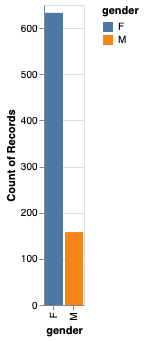

In [81]:
alt.Chart(df_merged).mark_bar().encode(
    x='gender:N',
    y='count()',
    color='gender'
)

### Age

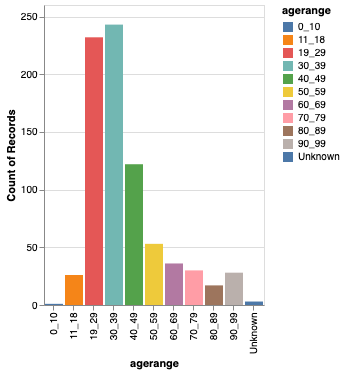

In [82]:
alt.Chart(df_merged).mark_bar().encode(
    x='agerange:O',
    y='count()',
    color='agerange'
)

## Texts

In [49]:
texts.head()

rec_length    rec_date  rec_year rec_period  n_speakers  \
S23A    1:50:43  2014-12-27      2014    2014_Q4           4   
S24A    0:17:24  2014-09-12      2014    2014_Q3           2   
S24D    0:20:00  2016-01-14      2016    2016_Q1           3   
S24E    0:45:53  2015-09-15      2015    2015_Q3           3   
S263    2:00:00  2016-02-07      2016    2016_Q1           4   

                list_speakers                    rec_loc  \
S23A  S0021 S0032 S0094 S0095             Speakers' home   
S24A              S0261 S0262  Modern Art Museum, London   
S24D        S0653 S0654 S0655    Home kitchen, Comberton   
S24E        S0519 S0520 S0521          Hunsonby, Cumbria   
S263  S0588 S0589 S0590 S0616                ANON’s home   

                                   relationships  \
S23A  Close family, partners, very close friends   
S24A  Close family, partners, very close friends   
S24D  Close family, partners, very close friends   
S24E  Close family, partners, very close friends   
S263  Close family, partners, very close friends   

                                                 topics  \
S23A  Computer programming, food, wine, temperature,...   
S24A                                            The art   
S24D                     Lego Ninjago, Minecraft worlds   
S24E  food, exercise, choir, family plans, family me...   
S263                                                NaN   

                                               activity  \
S23A     Catching up with family over food and presents   
S24A         A couple discussing modern art at a museum   
S24D  Spending time on electronic toys instead of re...   
S24E                              Midweek family dinner   
S263                                                NaN   

                                              conv_type conventions in_sample  \
S23A           Discussing, explaining, anecdote telling     Revised         n   
S24A                  Discussing, explaining, inquiring     Revised         y   
S24D                              Discusing, explaining     Revised         n   
S24E  Discussing, explaining, Inquiring, advising, a...     Revised         n   
S263                             Discussing, explaining     Revised         n   

     transcriber  
S23A         T15  
S24A         T09  
S24D         T18  
S24E         T09  
S263         T10

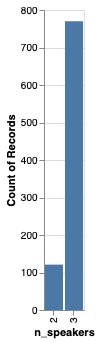

In [51]:
alt.Chart(df_merged).mark_bar().encode(
    x='n_speakers:O',
    y='count()',
)